In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from scipy import special as sp
import scipy.integrate as integrate
from scipy import optimize
rng = np.random.default_rng()
from tqdm import tqdm

In [2]:
#variaveis e constantes
fine_strc_const = 1/137          #[no units] fine-structure constant
mass_electron = 1.67*10**(-27)   #[Kg] massa do eletrao
h_bar = 6.626*10**(-34)/(2*pi)   #[J.s] constante de planck barra
spd_light = 3 * 10**8            #[m/s] velocidade da luz no vazio
lrtz_factor = 5                  #[no units] fator de lorentz
omega = 10**5                    #[1/s] frequencia do fotao
num_pon = 100                 #número de pontos
n_bins = 10                     #número de bins
n_gra_1 = 4                      #número de gráficos da primeira equação
n_gra_2 = 4                      #número de gráficos da segunda equação
X_e_0 = 0.5                      #valor inicial de energia do eletrão considerado
X_gamma_0 = 0.5                  #valor inicial de energia do fotão considerado
colorlst = ['red', 'orange', 'green', 'blue', 'black', 'yellow']     #lista de cores dos gráficos

In [3]:
def X_e_v(num):                 #gerar o valor de energia do eletrão
    return X_e_0 * 10**num

def X_gamma_v(num):
    return np.linspace(0.000001, X_e_v(num) * 0.9999, num_pon)

def Epsilon_v(num):
    return X_gamma_v(num) / X_e_v(num)

def d2P_dtdX(x1, num):  # funcao analitica nao normalizada de compton scattering
    X_e = X_e_v(num)
    X_tilde = 2 * x1 / (3 * X_e * (1 - x1))
    return x1 * X_e / (np.sqrt(3) * pi * lrtz_factor * X_e) * (
                (1 - x1 + 1 / (1 - x1)) * sp.kv(2 / 3, X_tilde))

def d2P_dtdX_norm(x1, integ, num):  # funcao analitica normalizada de compton scattering
    X_e = X_e_v(num)
    X_tilde = 2 * x1 / (3 * X_e * (1 - x1))
    return (x1 * X_e / (np.sqrt(3) * pi * lrtz_factor * X_e) * (
        (1 - x1 + 1 / (1 - x1)) * sp.kv(2 / 3, X_tilde))) / integ


N_d2P_dtdX = np.array([d2P_dtdX(Epsilon_v(i), i) for i in tqdm(range(n_gra_1))])

integ = np.array([np.trapz(N_d2P_dtdX[i], Epsilon_v(i)) for i in tqdm(range(n_gra_1))])  # integral da funcao analitica de compton scattering

for i in tqdm(range(n_gra_1)):
    N_d2P_dtdX[i] /= integ[i]

<ipython-input-3-ce113a72e64b>:23: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  N_d2P_dtdX = np.array([d2P_dtdX(Epsilon_v(i), i) for i in tqdm(range(n_gra_1))])
100%|██████████| 4/4 [00:00<?, ?it/s]


In [4]:
def X_gamma_v_2(num):               #gerar o valor de energia do fotão
    return X_gamma_0 * 10**num

def X_e_v_2(num):
    return np.linspace(0.000001, X_gamma_v_2(num) * 0.9999, num_pon)

def Epsilon_v_2(num):
    return X_e_v_2(num) / X_gamma_v_2(num)

def d2P_dtdX_2(x1, num):  # funcao analitica nao normalizada da geração de pares de eletrões e positrões
    X_gamma = X_gamma_v_2(num)
    X_tilde = 2 / (3 * X_gamma * (1 - x1) * x1)
    return fine_strc_const * mass_electron ** 2 * spd_light ** 4 / (np.sqrt(3) * pi * h_bar * omega * X_gamma) * ((x1 / (1 - x1) + ((1 - x1) / x1)) * sp.kv(2 / 3,X_tilde))

def d2P_dtdX_norm_2(x1, integ, num):  # funcao analitica normalizada da geração de pares de eletrões e positrões
    X_gamma = X_gamma_v_2(num)
    X_tilde = 2 / (3 * X_gamma * (1 - x1) * x1)
    return fine_strc_const * mass_electron ** 2 * spd_light ** 4 / (np.sqrt(3) * pi * h_bar * omega * X_gamma) * ((x1 / (1 - x1) + ((1 - x1) / x1)) * sp.kv(2 / 3,X_tilde))/integ


N_d2P_dtdX_2 = np.array([d2P_dtdX_2(Epsilon_v_2(i), i) for i in tqdm(range(n_gra_2))])

integ_2 = np.array([np.trapz(N_d2P_dtdX_2[i], Epsilon_v_2(i)) for i in tqdm(range(n_gra_2))])  # integral da funcao analitica da geração de pares de eletrões e positrões

for i in tqdm(range(n_gra_2)):
    N_d2P_dtdX_2[i] /= integ_2[i]

100%|██████████| 4/4 [00:00<?, ?it/s]


In [5]:
#inverse transform sampling method de compton scattering

def inverse_tramsform_sampling(num):

    def dP_dt(x1):  # CDF
        return integrate.quad(lambda x: d2P_dtdX_norm(x, integ[num], num), 0, x1)[0]


    # metodo para inverter a funcao

    def dP_dt_inverse_aux(y, x):
        return dP_dt(y) - x


    def dP_dt_inverse(x):
        return optimize.bisect(dP_dt_inverse_aux, 0.0000001, 0.999999, args=(x))

    uni_rnd = rng.random(num_pon)

    dP_dt_ICDF = np.array([dP_dt_inverse(x) for x in uni_rnd])  # IDCF

    return dP_dt_ICDF

In [6]:
#rejection method de compton scattering

def rejection_method(num):
    i = 0
    max_func = np.max(N_d2P_dtdX[num])  # maximo da funcao analitica
    d2P_dtdX_Rej = np.zeros(num_pon)
    while (i < num_pon):
        x = rng.random()
        y = rng.random()
        if (y < d2P_dtdX_norm(x, integ[num], num) / max_func):
            d2P_dtdX_Rej[i] = x  # distribuicao gerada pelo rejection method
            i += 1

    return d2P_dtdX_Rej

In [7]:
#inverse transform sampling method de produção de pares de eletrões e positrões

def inverse_tramsform_sampling_2(num):

    def dP_dt(x1):  # CDF
        return integrate.quad(lambda x: d2P_dtdX_norm_2(x, integ_2[num], num), 0, x1)[0]


    # metodo para inverter a funcao

    def dP_dt_inverse_aux(y, x):
        return dP_dt(y) - x


    def dP_dt_inverse(x):
        return optimize.bisect(dP_dt_inverse_aux, 0.0000001, 0.999999, args=(x))

    uni_rnd = rng.random(num_pon)

    dP_dt_ICDF = np.array([dP_dt_inverse(x) for x in uni_rnd])  # IDCF

    return dP_dt_ICDF

In [8]:
#rejection method de produção de pares de eletrões e positrões

def rejection_method_2(num):
    i = 0
    max_func = np.max(N_d2P_dtdX_2[num])  # maximo da funcao analitica
    d2P_dtdX_Rej = np.zeros(num_pon)
    while (i < num_pon):
        x = rng.random()
        y = rng.random()
        if (y < d2P_dtdX_norm_2(x, integ_2[num], num) / max_func):
            d2P_dtdX_Rej[i] = x  # distribuicao gerada pelo rejection method
            i += 1

    return d2P_dtdX_Rej

100%|██████████| 4/4 [00:36<00:00,  9.05s/it]


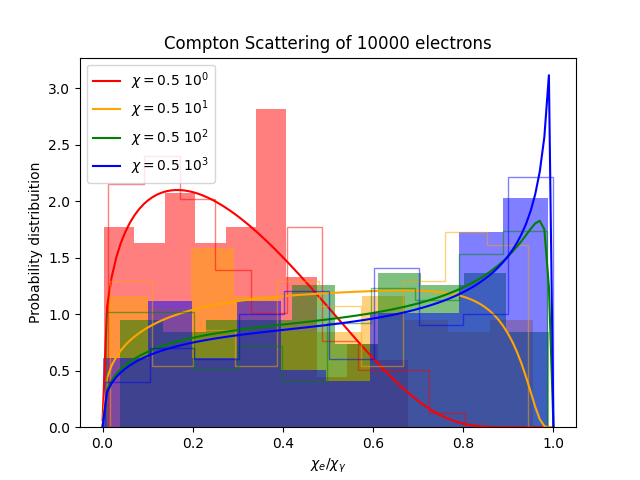

In [9]:
#graficos de compton scattering

for i in tqdm(range(n_gra_1)):
    plt.plot(Epsilon_v(i), N_d2P_dtdX[i], color=colorlst[i],
             label=r'$\chi=0.5~10^{}$'.format(
                 i))  # grafico da expressao analitica

    hist = inverse_tramsform_sampling(i)

    hist_2 = rejection_method(i)

    n_0, bins_0, patches_0 = plt.hist(hist, n_bins, density=True,
                                          color=colorlst[i], alpha=0.5,
                                            histtype='bar')  # histograma da ICDF

    n_1, bins_1, patches_1 = plt.hist(hist_2, n_bins, density=True,
                                      color=colorlst[i], alpha=0.5,
                                      histtype='step')  # histograma do rejection method

plt.title('Compton Scattering of 10000 electrons')

plt.xlabel('${\chi_{e}}/{\chi_\gamma}$')

plt.ylabel('Probability distribuition')

plt.legend()

plt.show()

plt.close()

100%|██████████| 4/4 [01:32<00:00, 23.09s/it]


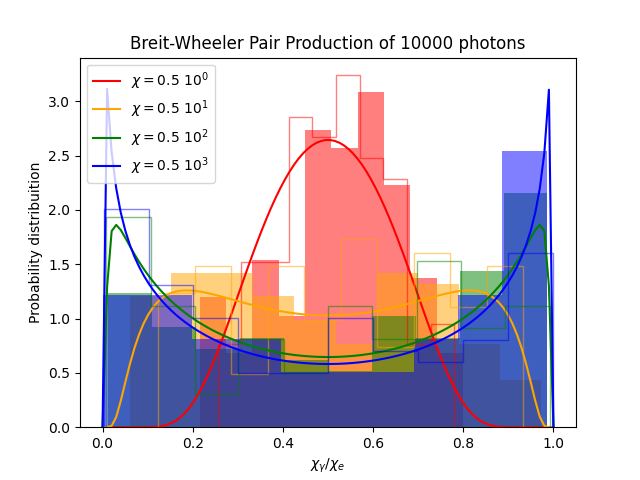

In [10]:
#graficos da produção de pares de eletrões e positrões

for i in tqdm(range(n_gra_2)):
    plt.plot(Epsilon_v_2(i), N_d2P_dtdX_2[i], color=colorlst[i],
             label=r'$\chi=0.5~10^{}$'.format(
                 i))  # grafico da expressao analitica

    hist_3 = inverse_tramsform_sampling_2(i)

    hist_4 = rejection_method_2(i)

    n_2, bins_2, patches_2 = plt.hist(hist_3, n_bins, density=True,
                                         color=colorlst[i], alpha=0.5,
                                           histtype='bar')  # histograma da ICDF

    n_3, bins_3, patches_3 = plt.hist(hist_4, n_bins, density=True,
                                      color=colorlst[i], alpha=0.5,
                                      histtype='step')  # histograma do rejection method

plt.title('Breit-Wheeler Pair Production of 10000 photons')

plt.xlabel('${\chi_{\gamma}}/{\chi_{e}}$')

plt.ylabel('Probability distribuition')

plt.legend()

plt.show()

plt.close()